In [61]:
# The usual suspects (and json)
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from nltk.stem import PorterStemmer
from nltk import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.manifold import TSNE
import nltk

from helper_functions.lyrics_cleaners import rep_linebrk, display_topics

# Pipeline functions
from helper_functions.pipeline import NLPPipe

# # Helper functions
# from Py_Files.helper_functions import txt_to_df, scatter, display_topics

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_proj = pd.read_pickle("AllBeatlesProj.pkl")

In [4]:
all_proj = all_proj.reset_index()
all_proj = all_proj.drop_duplicates(subset='song_title').reset_index().drop(columns='index')
all_proj['lyrics'] = all_proj['lyrics'].apply(lambda x: rep_linebrk(x))

In [5]:
corpus_list = all_proj['lyrics'].tolist()
# Let's turn all of the tweets into a list, so our Pipeline
# can work with our data better

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('oh')
stopwords.append('ve')
stopwords.append('ll')
stopwords.append('ooh')
stopwords.append('na')
stopwords.append('la')
stopwords.append('ca')
stopwords.append('wo')
stopwords.append('ah')
stopwords.append('yeah')
stopwords.append('oo')
stopwords.append('woah')
stopwords.append('well')
stopwords.append('doo')
stopwords.append('da')
stopwords.append('mm')
stopwords.append('mmm')
stopwords.append('uh')
stopwords.append('hey')
stopwords.append('go')
stopwords.append('know')
stopwords.append('like')
stopwords.append('see')
stopwords.append('get')
stopwords.append('got')
stopwords.append('one')
stopwords.append('way')
stopwords.append('could')
stopwords.append('make')
stopwords.append('thing')
stopwords.append('whoa')
stopwords.append('let')
stopwords.append('would')
stopwords.append('woo')
stopwords.append('love')
stopwords.append('yes')
stopwords.append('gonna')
stopwords.append('caus')
stopwords.append('come')
stopwords.append('want')
stopwords.append('though')
stopwords.append('say')

In [7]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words=stopwords, max_df=0.80, min_df=10), 
              tokenizer=TweetTokenizer().tokenize, 
              stemmer=SnowballStemmer("english",ignore_stopwords=True))
# TF-IDF may be better for our dataset. It works better with sparse datasets

In [8]:
nlp.fit(corpus_list)
dtm_tfidf = nlp.transform(corpus_list)
# Fit the corpus and transform the corpus

In [14]:
nmf_model = NMF(6, random_state=1)
doc_topic = nmf_model.fit_transform(dtm_tfidf)
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 25)
# These topics look a bit better than LDA.
# 0 - IDK, # 1 - Love, # 2 - Relationships, # 3 - Longing, # 4 - Desire, # 5 - Rock N Roll


Topic  0
tell, feel, never, need, right, think, hold, true, heart, much, pleas, believ, time, mind, night, realli, cri, word, ever, alway, call, dream, blue, noth, darl

Topic  1
babi, man, said, cri, pleas, mayb, fine, woman, run, leav, drive, bye, honey, shake, wait, keep, tri, name, ride, realli, girl, hold, tomorrow, sit, everybodi

Topic  2
look, girl, good, boy, nobodi, day, turn, life, man, knew, anoth, chang, find, saw, everi, said, around, head, dear, kind, world, sky, lose, everybodi, someon

Topic  3
back, long, take, time, home, wait, song, day, away, play, sing, keep, roll, fli, everi, night, old, without, heart, till, tear, alway, road, face, forget

Topic  4
littl, ladi, end, show, life, bit, friend, run, shake, think, woman, help, everi, anoth, hide, child, hard, rememb, flower, town, time, walk, play, danc, tri

Topic  5
give, peopl, free, live, world, mani, lord, us, peac, someth, tri, right, money, power, true, take, away, help, without, save, hope, light, heart, li

In [15]:
H = pd.DataFrame(doc_topic.round(5),
             index = corpus_list,
             columns = range(6))

In [16]:
all_proj['song_topic'] = H.idxmax(axis=1).tolist()

In [17]:
all_proj['song_topic'].value_counts()

3    249
0    244
2    138
5    127
1     63
4     50
Name: song_topic, dtype: int64

In [18]:
all_proj[all_proj['singer']=='Starr']['song_topic'].value_counts()

3    41
2    31
0    28
5    15
4     9
1     7
Name: song_topic, dtype: int64

In [19]:
plotting_x = TSNE(random_state=0,perplexity=50,metric='cosine').fit_transform(H)

In [20]:
all_proj['x'] = plotting_x[:,1]
all_proj['y'] = plotting_x[:,0]

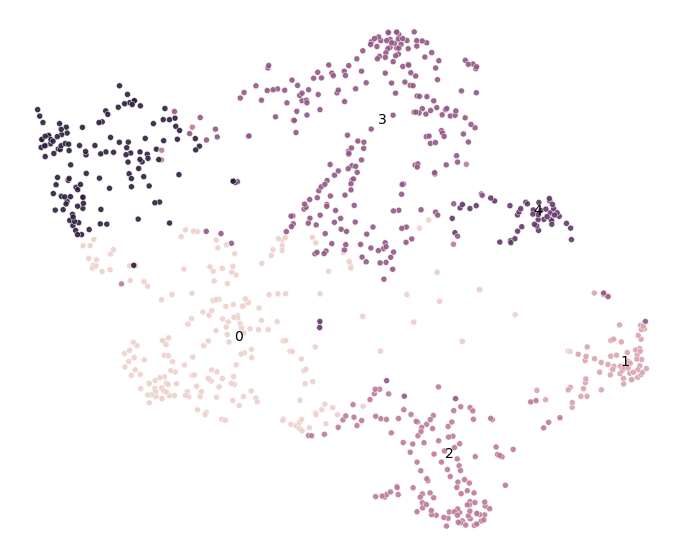

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
sns.scatterplot(all_proj['x'],all_proj['y'],hue=all_proj['song_topic'],alpha=0.9)
txts = []
for i in [0,1,2,3,4]:
    xtext, ytext = np.median(all_proj[all_proj['song_topic']==i].loc[:,'x':'y'],axis=0)
    txt = ax.text(xtext, ytext, i, fontsize=14)
    txts.append(txt)
ax.get_legend().remove()
# plt.title('Smaller Topics for {}'.format(int(df['year'].median())))
plt.axis('off');

In [22]:
beatles = pd.read_pickle("AllBeatlesProj.pkl")

In [23]:
beatles = beatles[beatles['artist']=='The Beatles']

In [24]:
beatles = beatles.reset_index()
beatles = beatles.drop_duplicates(subset='song_title').reset_index().drop(columns='index')
beatles['lyrics'] = beatles['lyrics'].apply(lambda x: rep_linebrk(x))

In [25]:
beatles

,song_title,artist,album_title,release_date,lyrics,singer
0,Taxman,The Beatles,Revolver (UK),1966-08-05 00:00:00,"One, two, three, four One, two... (One, two, ...",Harrison
1,Eleanor Rigby,The Beatles,Revolver (UK),1966-08-05 00:00:00,"Ah, look at all the lonely people! Ah, look at...",McCartney
2,I'm Only Sleeping,The Beatles,Revolver (UK),1966-08-05 00:00:00,When I wake up early in the morning Lift my he...,Lennon
3,Love You To,The Beatles,Revolver (UK),1966-08-05 00:00:00,"Each day just goes so fast I turn around, it's...",Harrison
4,"Here, There and Everywhere",The Beatles,Revolver (UK),1966-08-05 00:00:00,To lead a better life I need my love to be her...,McCartney
...,...,...,...,...,...,...
173,Honey Pie,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,She was a working girl North of England way No...,McCartney
174,Savoy Truffle,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,Creme tangerine and Montelimar A ginger sling ...,Harrison
175,Cry Baby Cry,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,Cry baby cry Make your mother sigh She's old e...,Lennon
176,Revolution 9,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,...bottle of claret for you if I'd realised. I...,"""Instrumental"""


In [26]:
corpus_list = beatles['lyrics'].tolist()
# Let's turn all of the tweets into a list, so our Pipeline
# can work with our data better

In [27]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words=stopwords, max_df=0.80, min_df=10), 
              tokenizer=TweetTokenizer().tokenize, 
              stemmer=SnowballStemmer("english",ignore_stopwords=True))
# TF-IDF may be better for our dataset. It works better with sparse datasets

In [28]:
nlp.fit(corpus_list)
dtm_beatles = nlp.transform(corpus_list)
# Fit the corpus and transform the corpus

In [29]:
nmf_model = NMF(5, random_state=0)
doc_topic = nmf_model.fit_transform(dtm_beatles)
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)
# 0 - Desire, # 1 - Reality, # 2 - Relationships, # 3 - Home, # 4 - Fun


Topic  0
need, tell, right, never, think, feel, mind, word, pleas, look, day, noth, good, time, still

Topic  1
babi, man, said, littl, fine, think, work, tell, feel, everybodi, old, run, right, tri, nobodi

Topic  2
girl, mine, day, look, anoth, kind, good, pleas, littl, chang, give, everi, take, better, run

Topic  3
back, cri, home, sing, sky, wait, blue, heart, never, lone, world, round, keep, eye, sit

Topic  4
long, danc, time, sing, boy, day, wait, tear, mani, happi, stand, pleas, heart, ever, night


In [30]:
H = pd.DataFrame(doc_topic.round(5),
             index = corpus_list,
             columns = range(5))

In [31]:
beatles['song_topic'] = H.idxmax(axis=1).tolist()
beatles['song_topic'].value_counts()

0    79
3    37
2    23
4    22
1    17
Name: song_topic, dtype: int64

In [32]:
album_titles = beatles['album_title'].unique().tolist()

In [33]:
topics = {}
for album in album_titles:
    topics[album]= beatles[beatles['album_title']==album]['song_topic'].value_counts()
    # topics.append(beatles[beatles['album_title']==album]['song_topic'].value_counts())

In [163]:
topic_df = pd.DataFrame(topics).T.fillna(0)

In [35]:
dates = beatles[['album_title','release_date']].drop_duplicates()['release_date']

In [36]:
dates.reset_index(drop=True,inplace=True)

In [37]:
dates

0     1966-08-05 00:00:00
1     1965-12-03 00:00:00
2     1965-08-06 00:00:00
3     1963-03-22 00:00:00
4     1963-11-22 00:00:00
5     1964-06-26 00:00:00
6     1970-05-08 00:00:00
7     1967-11-27 00:00:00
8     1964-12-04 00:00:00
9     1967-05-26 00:00:00
10    1969-09-26 00:00:00
11    1969-11-03 00:00:00
12    1968-11-22 00:00:00
Name: release_date, dtype: object

In [38]:
topic_df['release_date']=dates

In [39]:
for inx, date in enumerate(dates):
    topic_df.iloc[inx,5] = date

In [40]:
topic_df

,0,1,2,3,4,release_date
Revolver (UK),10.0,1.0,1.0,1.0,1.0,1966-08-05 00:00:00
Rubber Soul (UK),7.0,2.0,3.0,1.0,1.0,1965-12-03 00:00:00
Help! (UK),7.0,1.0,4.0,2.0,0.0,1965-08-06 00:00:00
Please Please Me,3.0,3.0,2.0,3.0,3.0,1963-03-22 00:00:00
With the Beatles,4.0,2.0,0.0,5.0,3.0,1963-11-22 00:00:00
A Hard Day’s Night (US),2.0,0.0,1.0,3.0,2.0,1964-06-26 00:00:00
Let It Be,5.0,1.0,3.0,2.0,1.0,1970-05-08 00:00:00
Magical Mystery Tour (US),4.0,1.0,0.0,3.0,2.0,1967-11-27 00:00:00
Beatles for Sale,5.0,4.0,2.0,2.0,1.0,1964-12-04 00:00:00
Sgt. Pepper’s Lonely Hearts Club Band,7.0,0.0,1.0,4.0,1.0,1967-05-26 00:00:00


In [41]:
topic_df['total_songs'] = topic_df.sum(axis=1)

In [42]:
topic_df

,0,1,2,3,4,release_date,total_songs
Revolver (UK),10.0,1.0,1.0,1.0,1.0,1966-08-05 00:00:00,14.0
Rubber Soul (UK),7.0,2.0,3.0,1.0,1.0,1965-12-03 00:00:00,14.0
Help! (UK),7.0,1.0,4.0,2.0,0.0,1965-08-06 00:00:00,14.0
Please Please Me,3.0,3.0,2.0,3.0,3.0,1963-03-22 00:00:00,14.0
With the Beatles,4.0,2.0,0.0,5.0,3.0,1963-11-22 00:00:00,14.0
A Hard Day’s Night (US),2.0,0.0,1.0,3.0,2.0,1964-06-26 00:00:00,8.0
Let It Be,5.0,1.0,3.0,2.0,1.0,1970-05-08 00:00:00,12.0
Magical Mystery Tour (US),4.0,1.0,0.0,3.0,2.0,1967-11-27 00:00:00,10.0
Beatles for Sale,5.0,4.0,2.0,2.0,1.0,1964-12-04 00:00:00,14.0
Sgt. Pepper’s Lonely Hearts Club Band,7.0,0.0,1.0,4.0,1.0,1967-05-26 00:00:00,13.0


In [43]:
for topic in [0,1,2,3,4]:
    topic_df[str(topic) + 'perc'] = topic_df[topic]/topic_df['total_songs']

In [44]:
topic_df

,0,1,2,3,4,release_date,total_songs,0perc,1perc,2perc,3perc,4perc
Revolver (UK),10.0,1.0,1.0,1.0,1.0,1966-08-05 00:00:00,14.0,0.714286,0.071429,0.071429,0.071429,0.071429
Rubber Soul (UK),7.0,2.0,3.0,1.0,1.0,1965-12-03 00:00:00,14.0,0.500000,0.142857,0.214286,0.071429,0.071429
Help! (UK),7.0,1.0,4.0,2.0,0.0,1965-08-06 00:00:00,14.0,0.500000,0.071429,0.285714,0.142857,0.000000
Please Please Me,3.0,3.0,2.0,3.0,3.0,1963-03-22 00:00:00,14.0,0.214286,0.214286,0.142857,0.214286,0.214286
With the Beatles,4.0,2.0,0.0,5.0,3.0,1963-11-22 00:00:00,14.0,0.285714,0.142857,0.000000,0.357143,0.214286
A Hard Day’s Night (US),2.0,0.0,1.0,3.0,2.0,1964-06-26 00:00:00,8.0,0.250000,0.000000,0.125000,0.375000,0.250000
Let It Be,5.0,1.0,3.0,2.0,1.0,1970-05-08 00:00:00,12.0,0.416667,0.083333,0.250000,0.166667,0.083333
Magical Mystery Tour (US),4.0,1.0,0.0,3.0,2.0,1967-11-27 00:00:00,10.0,0.400000,0.100000,0.000000,0.300000,0.200000
Beatles for Sale,5.0,4.0,2.0,2.0,1.0,1964-12-04 00:00:00,14.0,0.357143,0.285714,0.142857,0.142857,0.071429
Sgt. Pepper’s Lonely Hearts Club Band,7.0,0.0,1.0,4.0,1.0,1967-05-26 00:00:00,13.0,0.538462,0.000000,0.076923,0.307692,0.076923


In [45]:
topic_df.reset_index(inplace=True)
topic_df.rename({'index':'album_title'},inplace=True)
topic_df.set_index('release_date',inplace=True)

In [47]:
topic_df

,index,0,1,2,3,4,total_songs,0perc,1perc,2perc,3perc,4perc
release_date,,,,,,,,,,,,
1966-08-05,Revolver (UK),10.0,1.0,1.0,1.0,1.0,14.0,0.714286,0.071429,0.071429,0.071429,0.071429
1965-12-03,Rubber Soul (UK),7.0,2.0,3.0,1.0,1.0,14.0,0.500000,0.142857,0.214286,0.071429,0.071429
1965-08-06,Help! (UK),7.0,1.0,4.0,2.0,0.0,14.0,0.500000,0.071429,0.285714,0.142857,0.000000
1963-03-22,Please Please Me,3.0,3.0,2.0,3.0,3.0,14.0,0.214286,0.214286,0.142857,0.214286,0.214286
1963-11-22,With the Beatles,4.0,2.0,0.0,5.0,3.0,14.0,0.285714,0.142857,0.000000,0.357143,0.214286
1964-06-26,A Hard Day’s Night (US),2.0,0.0,1.0,3.0,2.0,8.0,0.250000,0.000000,0.125000,0.375000,0.250000
1970-05-08,Let It Be,5.0,1.0,3.0,2.0,1.0,12.0,0.416667,0.083333,0.250000,0.166667,0.083333
1967-11-27,Magical Mystery Tour (US),4.0,1.0,0.0,3.0,2.0,10.0,0.400000,0.100000,0.000000,0.300000,0.200000
1964-12-04,Beatles for Sale,5.0,4.0,2.0,2.0,1.0,14.0,0.357143,0.285714,0.142857,0.142857,0.071429


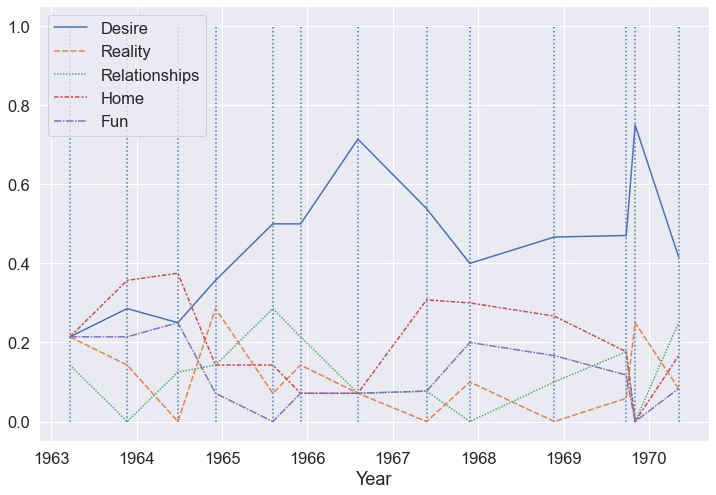

In [160]:
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
fig.set_size_inches(12,8)
sns.lineplot(data=topic_df.iloc[:,7:12])
plt.vlines(x=beatles_sent.index.tolist(),ymin=0,ymax=1,ls=':')
plt.xlabel('Year')
plt.legend(['Desire','Reality','Relationships','Home','Fun'])
plt.savefig('beatles_topics.png');

In [205]:
singer_top = beatles[['song_title','release_date','singer','song_topic','album_title']]

In [211]:
harrison_top = singer_top[singer_top['singer']=='Harrison'].set_index('release_date')
starr_top = singer_top[singer_top['singer']=='Starr'].set_index('release_date')
mccartney_top = singer_top[singer_top['singer']=='McCartney'].set_index('release_date')
lennon_top = singer_top[singer_top['singer']=='Lennon'].set_index('release_date')

<AxesSubplot:xlabel='song_topic'>

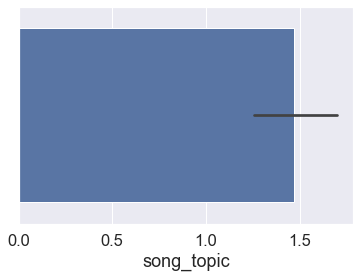

In [218]:
sns.barplot(singer_top['song_topic'])

In [208]:
harrison_top['song_topic'].value_counts()

0    14
4     5
3     3
2     2
1     2
Name: song_topic, dtype: int64

In [210]:
starr_top['song_topic'].value_counts()

0    5
1    2
4    1
3    1
2    1
Name: song_topic, dtype: int64

In [212]:
mccartney_top['song_topic'].value_counts()

0    26
3    16
4     9
2     6
1     1
Name: song_topic, dtype: int64

In [213]:
lennon_top['song_topic'].value_counts()

0    33
3    17
2    14
1    12
4     7
Name: song_topic, dtype: int64

In [186]:
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
fig.set_size_inches(12,8)
sns.lineplot(data=singer_top,hue='song_topic')
plt.vlines(x=beatles_sent.index.tolist(),ymin=0,ymax=1,ls=':')
plt.xlabel('Year')
plt.legend(['Desire','Reality','Relationships','Home','Fun'])
# plt.savefig('beatles_topics.png');

ValueError: The following variable cannot be assigned with wide-form data: `hue`

In [178]:
singer_top = singer_top.reset_index(level=0)

In [179]:
singer_top[singer_top['singer']!='"Instrumental"']

,singer,song_topic
release_date,,
1963-03-22,Harrison,2.500000
1963-11-22,Harrison,2.000000
1964-06-26,Harrison,4.000000
1964-12-04,Harrison,1.000000
1965-08-06,Harrison,1.500000
1965-12-03,Harrison,0.000000
1966-08-05,Harrison,1.333333
1967-05-26,Harrison,0.000000
1967-11-27,Harrison,4.000000


In [48]:
album_titles

['Revolver (UK)',
 'Rubber Soul (UK)',
 'Help! (UK)',
 'Please Please Me',
 'With the Beatles',
 'A Hard Day’s Night (US)',
 'Let It Be',
 'Magical Mystery Tour (US)',
 'Beatles for Sale',
 'Sgt. Pepper’s Lonely Hearts Club Band',
 'Abbey Road',
 'Yellow Submarine',
 'The Beatles (The White Album)']

In [62]:
sid = SentimentIntensityAnalyzer()

In [63]:
song2 = beatles.lyrics[1]

In [64]:
beatles['sentiment'] = ''

In [65]:
beatles

,song_title,artist,album_title,release_date,lyrics,singer,song_topic,sentiment
0,Taxman,The Beatles,Revolver (UK),1966-08-05 00:00:00,"One, two, three, four One, two... (One, two, ...",Harrison,0,
1,Eleanor Rigby,The Beatles,Revolver (UK),1966-08-05 00:00:00,"Ah, look at all the lonely people! Ah, look at...",McCartney,3,
2,I'm Only Sleeping,The Beatles,Revolver (UK),1966-08-05 00:00:00,When I wake up early in the morning Lift my he...,Lennon,0,
3,Love You To,The Beatles,Revolver (UK),1966-08-05 00:00:00,"Each day just goes so fast I turn around, it's...",Harrison,4,
4,"Here, There and Everywhere",The Beatles,Revolver (UK),1966-08-05 00:00:00,To lead a better life I need my love to be her...,McCartney,0,
...,...,...,...,...,...,...,...,...
173,Honey Pie,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,She was a working girl North of England way No...,McCartney,3,
174,Savoy Truffle,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,Creme tangerine and Montelimar A ginger sling ...,Harrison,0,
175,Cry Baby Cry,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,Cry baby cry Make your mother sigh She's old e...,Lennon,3,
176,Revolution 9,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,...bottle of claret for you if I'd realised. I...,"""Instrumental""",0,


In [66]:
sdict = []
for inx, lyrics in enumerate(beatles.lyrics):
    ss = sid.polarity_scores(lyrics)
    ss['song_title'] = beatles.song_title[inx]
    sdict.append(ss)

In [67]:
beatles['sentiment'] = pd.DataFrame(sdict)['compound']

In [68]:
beatles.sort_values(by='sentiment').head(5)

,song_title,artist,album_title,release_date,lyrics,singer,song_topic,sentiment
153,The Continuing Story of Bungalow Bill,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,"Hey, Bungalow Bill What did you kill, Bungalow...",Lennon,3,-0.9979
132,I Want You (She's So Heavy),The Beatles,Abbey Road,1969-09-26 00:00:00,"I want you, I want you so bad I want you, I wa...",Lennon,0,-0.9966
77,Can't Buy Me Love,The Beatles,A Hard Day’s Night (US),1964-06-26 00:00:00,"Can't buy me love, love Can't buy me love I'll...",McCartney,0,-0.9931
68,Not a Second Time,The Beatles,With the Beatles,1963-11-22 00:00:00,You know you made me cry I see no use in wonde...,Lennon,3,-0.9930
34,Ticket to Ride,The Beatles,Help! (UK),1965-08-06 00:00:00,"I think I'm going to be sad, I think it's toda...",Lennon,1,-0.9919


In [69]:
beatles.sort_values(by='sentiment').tail(5)

,song_title,artist,album_title,release_date,lyrics,singer,song_topic,sentiment
142,The End,The Beatles,Abbey Road,1969-09-26 00:00:00,"Oh yeah, alright Are you going to be in my dre...",McCartney,0,0.9991
7,Good Day Sunshine,The Beatles,Revolver (UK),1966-08-05 00:00:00,Good day sunshine Good day sunshine Good day s...,McCartney,2,0.9991
49,Love Me Do,The Beatles,Please Please Me,1963-03-22 00:00:00,"Love, love me do You know I love you I'll alwa...",Lennon,0,0.9993
107,Eight Days a Week,The Beatles,Beatles for Sale,1964-12-04 00:00:00,"Ooh, I need your love, babe Guess you know it'...",Lennon,2,0.9994
99,All You Need Is Love,The Beatles,Magical Mystery Tour (US),1967-11-27 00:00:00,"Love, love, love Love, love, love Love, love, ...",Lennon,0,0.9998


In [81]:
beatles_sent = beatles.groupby(['album_title','release_date']).mean().reset_index(level=0)

In [85]:
beatles_sent.drop(labels='song_topic',axis=1,inplace=True)

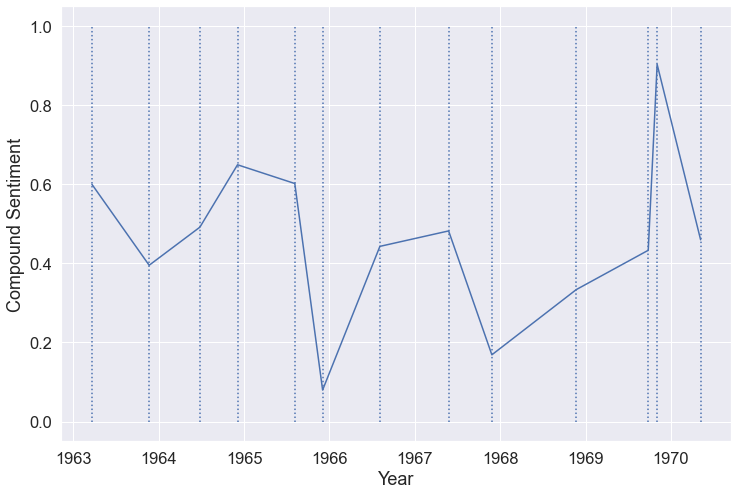

In [133]:
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
fig.set_size_inches(12,8)
sns.lineplot(data=beatles_sent)
plt.vlines(x=beatles_sent.index.tolist(),ymin=0,ymax=1,ls=':')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment')
ax.get_legend().remove();
# plt.savefig('beatles_sent.png');

In [135]:
sentiment = beatles.groupby(['album_title','singer','release_date']).mean()

In [136]:
sentiment = sentiment.drop(columns='song_topic')

In [145]:
sentiment.reset_index(level=[0,1],inplace=True)

In [149]:
sentiment = sentiment[sentiment['singer']!='"Instrumental"']

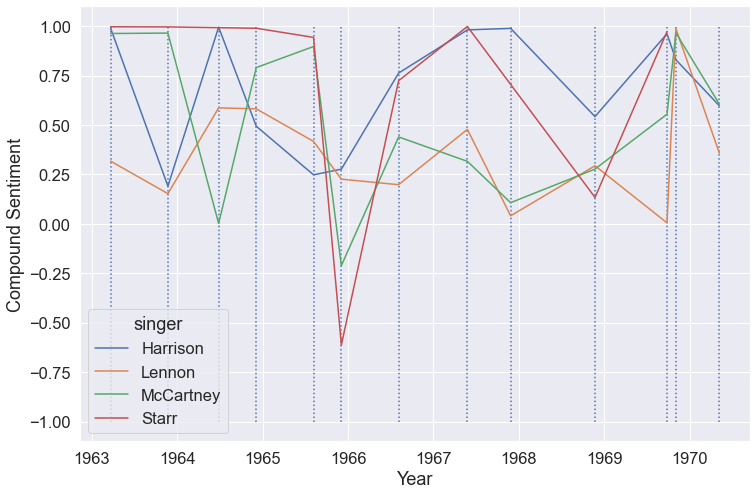

In [156]:
fig, ax = plt.subplots()
sns.lineplot(x='release_date',y='sentiment',data=sentiment,hue='singer')
fig.set_size_inches(12,8)
plt.vlines(x=beatles_sent.index.tolist(),ymin=-1,ymax=1,ls=':')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment');
# plt.savefig('members_sent.png');

In [606]:
n_sent[n_sent['singer']=='Harrison']

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,album_title,singer,release_date,sentiment
0,A Hard Day’s Night (US),Harrison,1964-06-26,0.995100
3,Abbey Road,Harrison,1969-09-26,0.961600
7,Beatles for Sale,Harrison,1964-12-04,0.493900
11,Help! (UK),Harrison,1965-08-06,0.248050
15,Let It Be,Harrison,1970-05-08,0.597450
18,Magical Mystery Tour (US),Harrison,1967-11-27,0.988900
21,Please Please Me,Harrison,1963-03-22,0.989300
25,Revolver (UK),Harrison,1966-08-05,0.762933
29,Rubber Soul (UK),Harrison,1965-12-03,0.276950
33,Sgt. Pepper’s Lonely Hearts Club Band,Harrison,1967-05-26,0.981300


In [527]:
beatles.lyrics

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      One, two, three, four One, two...  (One, two, ...
1      Ah, look at all the lonely people! Ah, look at...
2      When I wake up early in the morning Lift my he...
3      Each day just goes so fast I turn around, it's...
4      To lead a better life I need my love to be her...
                             ...                        
173    She was a working girl North of England way No...
174    Creme tangerine and Montelimar A ginger sling ...
175    Cry baby cry Make your mother sigh She's old e...
176    ...bottle of claret for you if I'd realised. I...
177    Now it's time to say good night Good night, sl...
Name: lyrics, Length: 178, dtype: object

In [515]:
ss2 = sid.polarity_scores(song2)

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [543]:
ss

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'neg': 0.024, 'neu': 0.889, 'pos': 0.087, 'compound': 0.6832}

In [524]:
ss2

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'neg': 0.201, 'neu': 0.765, 'pos': 0.034, 'compound': -0.9876}

In [648]:
nlp2 = NLPPipe(vectorizer=CountVectorizer(stop_words=stop2, max_df=0.80, min_df=10), 
              tokenizer=TweetTokenizer().tokenize, 
              stemmer=SnowballStemmer("english",ignore_stopwords=True))
# TF-IDF may be better for our dataset. It works better with sparse datasets

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [649]:
nlp2.fit(corpus_list)
dtm = nlp2.transform(corpus_list)

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [651]:
word_doc = pd.DataFrame(dtm.toarray(), columns=nlp2.vectorizer.get_feature_names())

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [673]:
word_doc.sum().sort_values(ascending=False)

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


love          438
yeah          269
want          201
girl          166
say           159
             ... 
seem           15
understand     14
must           13
late           13
fill           13
Length: 133, dtype: int64

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='Count'>

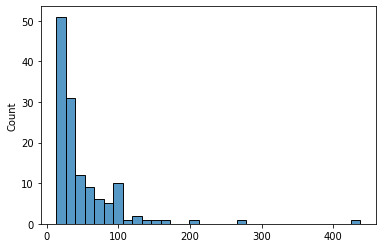

In [676]:
sns.histplot(word_doc.sum().sort_values(ascending=False))

In [647]:
stop2 = nltk.corpus.stopwords.words('english')
stop2.append('oh')
stop2.append('ve')
stop2.append('ll')
stop2.append('ooh')
stop2.append('na')
stop2.append('la')
stop2.append('ca')
stop2.append('wo')
stop2.append('ah')
stop2.append('oo')
stop2.append('woah')
stop2.append('doo')
stop2.append('da')
stop2.append('mm')
stop2.append('mmm')
stop2.append('uh')
stop2.append('hey')
stop2.append('go')
stop2.append('know')
stop2.append('like')
stop2.append('see')
stop2.append('get')
stop2.append('got')
stop2.append('one')
stop2.append('way')
stop2.append('could')
stop2.append('make')
stop2.append('thing')
stop2.append('whoa')
stop2.append('let')
stop2.append('would')
stop2.append('woo')
stop2.append('yes')
stop2.append('gonna')
stop2.append('caus')
stop2.append('come')
stop2.append('though')

/Users/joecowell/opt/anaconda3/envs/proj5/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
